<a href="https://colab.research.google.com/github/euvictorhfs/Dados/blob/main/CaseBI/amostraPetLove.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bibliotecas

In [ ]:
#!python -m pip uninstall matplotlib
#!pip install matplotlib==3.1.3

In [ ]:
#!pip install importlib-metadata==4.11.2

In [ ]:
#!pip install matplotlib --upgrade

In [ ]:
#!pip install seaborn --upgrade

In [ ]:
import numpy as np
import pandas as pd
#%matplotlib inline
import matplotlib as plt
import seaborn as sns
#import lifelines
import datetime as dt
from pandas.tseries import frequencies

In [ ]:
!pip install -q -U watermark
%reload_ext watermark
from platform import python_version
print('Versão do Python utilizado neste Notebook:', python_version())
%watermark -a "Victor Hugo Ferreira da Silva - Case BI PetLove&Co" --iversions
import warnings
import sys
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
if not sys.warnoptions:
    warnings.simplefilter("ignore")

Versão do Python utilizado neste Notebook: 3.7.12
Author: Victor Hugo Ferreira da Silva - Case BI PetLove&Co

seaborn   : 0.11.2
matplotlib: 3.2.2
numpy     : 1.21.5
IPython   : 5.5.0
pandas    : 1.3.5



In [ ]:
# Resumo do dataframe
def resumo(df):

    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['First Value'] = df.loc[0].values 
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    
    return summary

# Fonte de dados

Uso de dados com parcimônia para economia de processamento e recursos cloud em um contexto de governança entendendo quais dados são importantes a serem analisados.

In [ ]:
# Importação das 10 primeiras linhas
petlove = pd.read_csv ('https://s3.amazonaws.com/gupy5/production/companies/294/emails/1644871691997/68b12e50-8dd7-11ec-a146-f102a206148e/data-test-analytics.csv',
                       nrows=10)

In [ ]:
# Verificação da importação
print(petlove.shape)

(10, 20)


Antes de me aprofundar em todas as informações, vou analisar os primeiros registros para entender a base de dados.

## Briefing (Case BI)

In [ ]:
resumo(petlove)

Dataset Shape: (10, 20)


,index,dtypes,First Value,Missing,Uniques
0,id,object,8bf7960e-3b93-468b-856e-6c6c5b56f52b,0,10
1,created_at,object,08/15/17 07:05 AM,0,10
2,updated_at,object,01/14/21 11:23 AM,0,8
3,deleted_at,float64,NaN,10,0
4,name_hash,object,312d206168a318614897e8ccac43bff9,0,10
5,email_hash,object,83eb3aed9a44377df80ce876dce92c9a,0,10
6,address_hash,object,8b4bfaa0cbc41a16f46da15ddcd6a907,0,10
7,birth_date,object,07/10/74 12:00 AM,0,10
8,status,object,active,0,2
9,version,object,2.31.7,0,10


Com exceção dos valores numéricos, todos os outros valores são do tipo objeto. O briefing informa quais os dados criptografados.

Nesse ínterim, não irei importar as colunas criptografadas: ***name_hash***, ***email_hash*** e ***address_hash***.

Além destas, a coluna de ***IDs*** dos clientes também está criptografada e, para responder a pergunta de negócio, esse dado não é variável explicativa e também será removida.

In [ ]:
# remover colunas: id, name_hash, email_hash, address_hash.

Outras colunas que me despertaram atenção foram as ***city***, ***neighborhood*** e ***state***. Realizei uma pesquisa no www.google.com e não existe bairro chamado **Aparecida 7ª Seção no Amazonas**, nem a **cidade Peixoto da Praia no Amazonas**. Analisando outros valores, Braúnas, é uma cidade de Belo Horizonte, MG (não é de SC; não é um bairro). A coluna de cidades aparenta ser o sobrenome dos clientes.

In [ ]:
print(petlove.loc[:,['neighborhood','city','state']])

                neighborhood               city state
0         Aparecida 7ª Seção   Peixoto da Praia    AM
1               Santa Isabel          Fernandes    RR
2                    Estrela              Lopes    RR
3                   Confisco    Campos do Campo    PE
4  Vila Suzana Segunda Seção          das Neves    RJ
5                 Vila Maria             Aragão    AM
6                    Braúnas              Lopes    MT
7                    Bacurau     Pereira Grande    SC
8                     Piraja   Fernandes Alegre    PR
9            Padre Eustáquio     Cardoso do Sul    MT


In [ ]:
# remover colunas: neighborhood, city.

A coluna com campos vazios da ***deleted_at*** faz sentido, pois os clientes ativos não cancelaram sua assinatura e essa coluna servirá como base para criação de novos dados.

In [ ]:
print(petlove.loc[:,['deleted_at','status']])

   deleted_at  status
0         NaN  active
1         NaN  paused
2         NaN  active
3         NaN  active
4         NaN  active
5         NaN  active
6         NaN  active
7         NaN  active
8         NaN  active
9         NaN  active


In [ ]:
# criar coluna boleana Exit = "Sim, Não"
# criar coluna int Tenure = "tempo, em dias, que o cliente possuiu o serviço"
# após, deletar coluna deleted_at e status

## Contexto de negócio (Churn/Mkt)

Por fim, com essa primeira limpeza para evitar a poluição de informações, preciso entender o **contexto de negócio**: participar da equipe de assinatura para identificar **quem são os usuários** que tem probabilidade de cancelar a assinatura com base nos **indicadores de churn**.

Como meu papel será de apoio para agregar o *time de marketing*, minha análise exploratória será focada em **estatística descritiva**.

Entendendo esses dados e o contexto do negócio, agora irei **reimportar o dataset** economizando o processamento de dados via cloud, facilitando minha análise.

Vou aproveitar o ensejo para reimportar já categorizando os **tipos de dados**.

In [ ]:
# sumarizando nome das colunas para copiar
petlove.columns.values

array(['id', 'created_at', 'updated_at', 'deleted_at', 'name_hash',
       'email_hash', 'address_hash', 'birth_date', 'status', 'version',
       'city', 'state', 'neighborhood', 'last_date_purchase',
       'average_ticket', 'items_quantity', 'all_revenue', 'all_orders',
       'recency', 'marketing_source'], dtype=object)

In [ ]:
# Reimportando o dataset com conversão de objetos
petlove = pd.read_csv('https://s3.amazonaws.com/gupy5/production/companies/294/emails/1644871691997/68b12e50-8dd7-11ec-a146-f102a206148e/data-test-analytics.csv',
                 encoding='utf-8',
                 sep=',',
                 usecols=[
                   'created_at', 'updated_at', 'deleted_at', 'birth_date',
                   'status', 'version', 'state', 'last_date_purchase',
                   'average_ticket', 'items_quantity', 'all_revenue',
                   'all_orders', 'recency', 'marketing_source'],
                 dtype={
                     'status':'category',
                     'state':'category',
                     'marketing_source':'category'},
                  parse_dates=['created_at', 'updated_at', 'deleted_at', 'birth_date', 'last_date_purchase'],
                  )

In [ ]:
resumo(petlove)

Dataset Shape: (10000, 14)


,index,dtypes,First Value,Missing,Uniques
0,created_at,datetime64[ns],2017-08-15 07:05:00,0,9975
1,updated_at,datetime64[ns],2021-01-14 11:23:00,0,550
2,deleted_at,datetime64[ns],NaT,9495,505
3,birth_date,datetime64[ns],1974-07-10 00:00:00,0,7876
4,status,category,active,0,3
5,version,object,2.31.7,0,2905
6,state,category,AM,0,27
7,last_date_purchase,datetime64[ns],2021-01-14 11:23:00,0,550
8,average_ticket,float64,151.142942,0,10000
9,items_quantity,int64,10,0,19


In [ ]:
# Verificando a quantidade de colunas e linhas
print(petlove.shape)

(10000, 14)


In [ ]:
# Cópia do dataset
# Caso seja necessário retornar ao dataset
# Facilitar a nota variável intacta
# Nova nota variável para facilitar o entendimento dos meus pares (df)
df = petlove.copy()

# Pré-processamento dos dados

## deleted_at [*tenure*]

In [ ]:
# Tenure = Dias de serviço ativo
df['created_at'] = pd.to_datetime(df['created_at']).dt.normalize()
df['deleted_at'] = pd.to_datetime(df['deleted_at']).dt.normalize()
df['tenure'] = (df['deleted_at'] - df['created_at']).dt.days
df[df['tenure'] >= 0].value_counts().sum()

505

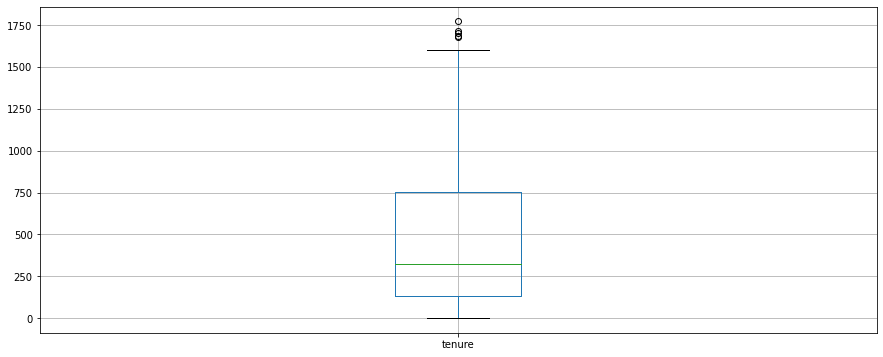

In [ ]:
df.boxplot(['tenure'], figsize=(15, 6))

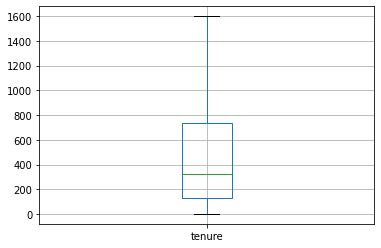

In [ ]:
valor_tenure = df['tenure']
Q1 = valor_tenure.quantile(.25)
Q3 = valor_tenure.quantile(.75)
IIQ = Q3 - Q1
limite_inferior = Q1 - 1.5 * IIQ
limite_superior = Q3 + 1.5 * IIQ

selecao = (valor_tenure >= limite_inferior) & (valor_tenure <= limite_superior)
dados_tenure = df[selecao]

dados_tenure.boxplot(['tenure'])

## status [*exit, target*]

In [ ]:
df.groupby('status')['status'].count()

status
active      8524
canceled     505
paused       971
Name: status, dtype: int64

In [ ]:
# Exit = Sim, Não
df.loc[df['status'] == 'active', 'exit'] = 'Não' 
df.loc[df['status'] == 'canceled', 'exit'] = 'Sim'
df.loc[df['status'] == 'paused', 'exit'] = 'Não'
df.exit.value_counts()

Não    9495
Sim     505
Name: exit, dtype: int64

In [ ]:
# Paused = Sim, Não
df.loc[df['status'] == 'active', 'target'] = 'Não' 
df.loc[df['status'] == 'canceled', 'target'] = 'Não'
df.loc[df['status'] == 'paused', 'target'] = 'Sim'
df.target.value_counts()

Não    9029
Sim     971
Name: target, dtype: int64

In [ ]:
active = df[df.status == 'active'].shape[0]
paused = df[df.status == 'paused'].shape[0]
canceled = df[df.status == 'canceled'].shape[0]
print(active / (active + paused + canceled) * 100, '% dos clientes possuem assinatura ativa.')
print(paused / (active + paused + canceled) * 100, '% dos clientes possuem assinatura pausada.')
print(canceled / (active + paused + canceled) * 100, '% dos clientes possuem assinatura cancelada.')

85.24000000000001 % dos clientes possuem assinatura ativa.
9.71 % dos clientes possuem assinatura pausada.
5.050000000000001 % dos clientes possuem assinatura cancelada.


In [ ]:
df = df.drop(['deleted_at'], axis=1)
df.head()

,created_at,updated_at,birth_date,status,version,state,last_date_purchase,average_ticket,items_quantity,all_revenue,all_orders,recency,marketing_source,tenure,exit,target
0,2017-08-15,2021-01-14 11:23:00,1974-07-10,active,2.31.7,AM,2021-01-14 11:23:00,151.142942,10,906.857651,6,35,crm,NaN,Não,Não
1,2019-12-31,2021-01-08 11:23:00,2040-07-06,paused,3.30.12,RR,2021-01-08 11:23:00,236.991790,4,236.991790,1,41,organic_search,NaN,Não,Sim
2,2019-03-07,2021-01-07 11:23:00,2063-03-18,active,3.28.9,RR,2021-01-07 11:23:00,211.955597,13,2331.511572,11,42,organic_search,NaN,Não,Não
3,2018-07-21,2021-01-10 11:23:00,1980-11-21,active,3.34.3,PE,2021-01-10 11:23:00,204.113227,8,1224.679359,6,39,organic_search,NaN,Não,Não
4,2018-06-08,2021-01-18 11:23:00,2059-07-07,active,3.19.8,RJ,2021-01-18 11:23:00,252.940997,9,2023.527980,8,31,crm,NaN,Não,Não


## birth_date [*age, senior_citizen, age_group*]

In [ ]:
# idade dos clientes
now = pd.Timestamp('now')
df['birth_date'] = pd.to_datetime(df['birth_date'], format='%Y/%m/%d')
df['birth_date'] = df['birth_date'].where(df['birth_date'] < now, df['birth_date'] - np.timedelta64(100, 'Y'))
df['age'] = (now - df['birth_date']).astype('<m8[Y]')
df['age'] = df.age.astype(int)
df['age'].describe()

count    10000.000000
mean        53.515800
std         16.046423
min         26.000000
25%         40.000000
50%         54.000000
75%         67.000000
max         82.000000
Name: age, dtype: float64

In [ ]:
df['age'] = pd.to_numeric(df['age'].astype(int))

In [ ]:
print(df.age.min())
print(df.age.max())

26
82


In [ ]:
# cliente é idoso?
df['senior_citizen'] = pd.cut(
    df['age'],
    bins = [26,65,82],
    ordered = True,
    labels = ['Não','Sim'],
    right=True
    )
df.senior_citizen.value_counts()

Não    7022
Sim    2811
Name: senior_citizen, dtype: int64

In [ ]:
# categorizando clientes por faixa de idade
# ... 26 a 34 | 35 a 44 | 45 a 54 | 55 a 64 | 65 ou mais
# Idade mínima: 26 anos - Idade máxima: 82 anos
# Fonte Google Ads: https://support.google.com/searchads/answer/6309527?hl=pt-BR

# faixa etaria
df['age_group'] = pd.cut(
    df['age'],
    bins = [0,26,35,45,55,65,100],
    ordered = True,
    labels = ['Até 26 anos','27 a 34 anos', '35 a 44 anos', '45 a 54 anos', '55 a 64 anos', '65 anos ou mais'],
    right=True
)
df.age_group.value_counts()

65 anos ou mais    2811
35 a 44 anos       1848
45 a 54 anos       1823
55 a 64 anos       1799
27 a 34 anos       1552
Até 26 anos         167
Name: age_group, dtype: int64

In [ ]:
df = df.drop(['birth_date'], axis=1)
df.head()

,created_at,updated_at,status,version,state,last_date_purchase,average_ticket,items_quantity,all_revenue,all_orders,recency,marketing_source,tenure,exit,target,age,senior_citizen,age_group
0,2017-08-15,2021-01-14 11:23:00,active,2.31.7,AM,2021-01-14 11:23:00,151.142942,10,906.857651,6,35,crm,NaN,Não,Não,47,Não,45 a 54 anos
1,2019-12-31,2021-01-08 11:23:00,paused,3.30.12,RR,2021-01-08 11:23:00,236.991790,4,236.991790,1,41,organic_search,NaN,Não,Sim,81,Sim,65 anos ou mais
2,2019-03-07,2021-01-07 11:23:00,active,3.28.9,RR,2021-01-07 11:23:00,211.955597,13,2331.511572,11,42,organic_search,NaN,Não,Não,59,Não,55 a 64 anos
3,2018-07-21,2021-01-10 11:23:00,active,3.34.3,PE,2021-01-10 11:23:00,204.113227,8,1224.679359,6,39,organic_search,NaN,Não,Não,41,Não,35 a 44 anos
4,2018-06-08,2021-01-18 11:23:00,active,3.19.8,RJ,2021-01-18 11:23:00,252.940997,9,2023.527980,8,31,crm,NaN,Não,Não,62,Não,55 a 64 anos


## version [*version_group*]

## series monthlyCharges

## Aa

In [ ]:
# Conversão de dtypes
df.info()

In [ ]:
# Dicionário de dados da Tabela
dicionario = {
    'id': ['Identificação do cliente'],
    'created_at': ['Data de criação da assinatura'],
    'updated_at': ['Data da última modificação da assinatura'],
    'deleted_at': ['Data de cancelamento da assinatura'],
    'name_hash': ['Nome do usuário (criptografado)'],
    'email_hash': ['Email (criptografado)'],
    'address_hash': ['Endereço (criptografado)'],
    'birth_date': ['Data de aniversário do cliente'],
    'status': ['Status da assinatura'],
    'version': ['Versão da assinatura'],
    'city': ['Cidade do cliente'],
    'state': ['Estado do cliente'],
    'neighborhood': ['Bairro do cliente'],
    'last_date_purchase': ['Data do último pedido que ocorreu pela assinatura'],
    'average_ticket': ['Média de gasto por pedido'],
    'items_quantity': ['Média de itens na assinatura'],
    'all_revenue': ['Total de receita realizado pelo cliente'],
    'all_orders': ['Total de pedidos realizado pelo cliente'],
    'recency': ['Tempo desde a última compra do cliente'],
    'marketing_source': ['Canal de marketing que converteu a assinatura']
}

In [ ]:
# Dicionário dos nomes dos dias
dias_ptbr = {
    'Sunday':'Domingo',
    'Monday':'Segunda-feira',
    'Tuesday':'Terça-feira',
    'Wednesday':'Quarta-feira',
    'Thursday':'Quinta-feira',
    'Friday':'Sexta-feira',
    'Saturday':'Sábado'
    }

In [ ]:
# Dicionário dos nomes dos meses
meses_ptbr = {
    'January':'Janeiro',
    'February':'Fevereiro',
    'March':'Março',
    'April':'Abril',
    'May':'Maio',
    'June':'Junho',
    'July':'Julho',
    'August':'Agosto',
    'September':'Setembro',
    'October':'Outubro',
    'November':'Novembro',
    'December':'Dezembro'
    }

In [ ]:
# Ajustes de visualização dos gráficos
#%pylab inline
#pylab.rcParams['figure.figsize'] = (14, 9)

In [ ]:
# Ajustes de visualização dos formatos númericos/decimais do dataframe
#pd.set_option('display.precision', 0)
#pd.set_option('float_format', '{:.0f}'.format)
#pd.options.display.float_format = '{:,.0f}'.format
#pd.set_option('display.expand_frame_repr', False)

# Análise exploratória inicial

In [ ]:
df.loc[1]

*   Os IDs dos clientes também estão criptografados.
*   A data de atualização da assinatura mostra a última atualização recebida no sistema.
*   A data de aniversário do cliente possuí outliers.
*   A data de aniversário do cliente irá gerar novas colunas como idade, faixa etária e se é idoso.
*   O registro de atualização da assinatura é igual a data de última compra.
*   O cliente fez a última compra em 08/01/2021 às 11:23; e
*   O cliente pausou a assinatura no mesmo minuto que realizou sua última compra.

In [ ]:
df.describe(include=['category', 'object'])

*   A maioria dos clientes possuí assinatura ativa.
*   O estado que mais possuí clientes é o Tocantins?
*   O marketing que mais converte assinaturas é o tráfego orgânico.
*   Existem 2.905 versões de assinaturas repetidas no total de 10.000?
*   A assinatura que mais se repete é a de número 4.26.7.

In [ ]:
df.describe(include=['datetime'])

*   A primeira assinatura foi criada em 19 de fevereiro de 2016 às 10:00.
*   A última assinatura foi criada em 18 de fevereiro de 2021 às 05:04.
*   Existem 629 atualizações de assinatura com horas e minutos iguais.
*   E existem exatamente 629 últimas compras realizadas em horas/minutos iguais a data de atualização da assinatura.
*   **A data de aniversário de alguns clientes possuí outliers.**
*   **Qual a correlação entre a data de atualização e a data de última compra?**
*   **Existe alguma correlação entre a data de atualização e a data de cancelamento da assinatura?**
*   **Qual a média, moda e mediana da idade dos clientes?**
*   **Os clientes são idosos?**

In [ ]:
df.describe()

*   Todos os clientes em todo o período gastam em média R$ 217,02.
*   Todos os clientes em todo o período compram em média 8 itens.
*   **O total de receita possuí outliers.**
*   **O total de pedidos possuí outliers no mínimo.**
*   **O total de dias de última compra possuí muitos outliers.**

# Análise exploratória

## Remoção de dados

É impossível prever se os clientes são únicos, pois os dados estão criptografados.
O Id não é variável explicativa.

In [ ]:
# Verificação de registros únicos
#print(df['id'].nunique())

# Remoção dos registros
#df.drop(
#    ['id'], axis=1, inplace=True
#)

## Dados temporais

In [ ]:
# Reclassificando as linhas em ordem crescente
#df.sort_values(by=['created_at'], ascending=True, inplace=True)

In [ ]:
# Datetime Series Created At
#created_datetime_series = pd.to_datetime(df['created_at'])
#created_dt_series = pd.DatetimeIndex(created_datetime_series.values)
#df = df.set_index(created_dt_series).set_index('created_at').rename_axis('Data de criação da assinatura')
#df.describe()

In [ ]:
# Datetime Series Updated At
#updated_datetime_series = pd.to_datetime(df['updated_at'])
#updated_dt_series = pd.DatetimeIndex(updated_datetime_series.values)
#df_mod = df.set_index(updated_dt_series).set_index('updated_at').rename_axis('Data da última modificação da assinatura')
#df_mod.describe()

# > CHECK ROWS (?)

In [ ]:
# Datetime Series Deleted At
#deleted_datetime_series = pd.to_datetime(df['deleted_at'])
#deleted_dt_series = pd.DatetimeIndex(deleted_datetime_series.values)
#df_mod = df.set_index(deleted_dt_series).set_index('deleted_at').rename_axis('Data de cancelamento da assinatura')
#df_mod.describe()

# > DROP ROWS NaT

In [ ]:
# Datetime Series Birth Date
#age_datetime_series = pd.to_datetime(df['birth_date'])
#age_dt_series = pd.DatetimeIndex(age_datetime_series.values)
#df_age = df.set_index(age_dt_series).set_index('birth_date').rename_axis('Data de aniversário do cliente')
#df_age.describe()

# > CHECK OUTLIERS

In [ ]:
# Datetime Series Last Date Purchase
#lastPurchase_datetime_series = pd.to_datetime(df['last_date_purchase'])
#lastPurchase_dt_series = pd.DatetimeIndex(lastPurchase_datetime_series.values)
#df_sales = df.set_index(lastPurchase_dt_series).set_index('last_date_purchase').rename_axis('Data do último pedido que ocorreu pela assinatura')
#df_sales.describe()

# > CHECK (?)

## Boxplot para outliers

In [ ]:
# Boxplot
boxplot_df = df

In [ ]:
boxplot_df.dtypes

In [ ]:
#boxplot_df['items_quantity'] = pd.to_numeric(df['items_quantity'], errors='coerce').astype('int')
#boxplot_df['all_orders'] = pd.to_numeric(df['all_orders'], errors='coerce').astype('int')
#boxplot_df['recency'] = pd.to_numeric(df['recency'], errors='coerce').astype('int')
#boxplot_df['all_revenue'] = pd.to_numeric(df['all_revenue'], errors='coerce').astype('float64')
#boxplot_df['average_ticket'] = pd.to_numeric(df['average_ticket'], errors='coerce').astype('float64')

In [ ]:
selectColsBoxplot = ['average_ticket', 'items_quantity', 'all_revenue', 'all_orders', 'recency']

In [ ]:
boxplot_df = boxplot_df.filter(items=selectColsBoxplot)
boxplot_df = boxplot_df.reset_index(drop=True)
boxplot_df

In [ ]:
boxplot_df.dtypes

In [ ]:
np.random.seed(1234)
df = pd.DataFrame(np.random.randn(10, 4),
                  columns=['average_ticket', 'all_revenue', 'all_items', 'all_orders', 'recency'])
boxplot = df.boxplot(column=['Col1', 'Col2', 'Col3'])  

In [ ]:
def plot_boxplot(df, ft):
  df.boxplot(column=[ft])
  plt.grid(False)
  plt.show()

In [ ]:
plot_boxplot(boxplot_df, 'average_ticket')

In [ ]:
plot_boxplot(boxplot_df, 'items_quantity')

In [ ]:
plot_boxplot(boxplot_df, 'all_revenue')

In [ ]:
plot_boxplot(boxplot_df, 'all_orders')

In [ ]:
plot_boxplot(boxplot_df, 'recency')

## remoção de outliers

In [ ]:
# IQR = Q3-Q1
# +/- 1.5*IQR

def outliers(df, ft):
  Q1 = df[ft].quantile(0.25)
  Q3 = df[ft].quantile(0.75)
  IQR = Q3 - Q1

  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR

  ls = df.index[ (df[ft] < lower_bound | df[ft] > upper_bound) ]

  return ls

In [ ]:
def plot_boxplot(df, ft):
  df.boxplot(column=[ft])
  plt.grid(False)
  plt.show()
  index_list = []
for feature in ['items_quantity', 'all_orders', 'recency']:
  index_list.extend(outliers(boxplot_df, feature))

In [ ]:
index_list

## deleted_at

In [ ]:
df.deleted_at.describe()

In [ ]:
df['deleted_at'].isnull().sum()

In [ ]:
#coluna de clientes que cancelaram a assinatura
df.loc[df['status'] == 'active', 'exit'] = 'Não'
df.loc[df['status'] == 'canceled', 'exit'] = 'Sim'
df.loc[df['status'] == 'paused', 'exit'] = 'Não'

In [ ]:
df['exit'].value_counts()
sns.countplot(df['exit'])

**clientes que cancelaram a assinatura:** 505

In [ ]:
# Existe alguma correlação entre o cancelamento de assinatura e a quantidade de pedidos?
df_exit_sim = df.drop('exit',axis=1)
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

## birth_date

In [ ]:
#coluna de idade dos clientes
now = pd.Timestamp('now')
df['birth_date'] = pd.to_datetime(df['birth_date'], format='%Y/%m/%d')
df['birth_date'] = df['birth_date'].where(df['birth_date'] < now, df['birth_date'] - np.timedelta64(100, 'Y'))
df['age'] = (now - df['birth_date']).astype('<m8[Y]')
df['age'].describe()

In [ ]:
df.age.mode()

In [ ]:
sns.displot(df, x='age',bins=[26,34,44,54,64,82])

In [ ]:
df.query('age < 65').describe()

In [ ]:
sns.displot(df, x='age',bins=[26,34,44,54,64])

Média de clientes abaixo dos 65 anos
*   **Idade mínima:** 26 anos
*   **Idade máxima:** 64 anos
*   **Idade média:** 45 anos

In [ ]:
df.query('age > 65').describe()

In [ ]:
df.query('age >= 55 & age <= 64').describe()

### seniorCitizen

In [ ]:
#cliente é idoso?
df['seniorCitizen'] = pd.cut(
    df['age'],
    bins = [0,65,sys.maxsize],
    ordered = True,
    labels = ['Não','Sim'],
    right=True
)
df.seniorCitizen.value_counts()

In [ ]:
sns.displot(df, x='age',bins=[65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82])

**Total de clientes idosos:** 2.804

### ageGroup

Insight: Agrupando clientes por faixa de idade em nova coluna
... 26 a 34 | 35 a 44 | 45 a 54 | 55 a 64 | 65 ou mais
Idade mínima: 26 anos - Idade máxima: 82 anos
Fonte Google Ads: https://support.google.com/searchads/answer/6309527?hl=pt-BR


In [ ]:
#faixa etaria clientes
df['ageGroup'] = pd.cut(
    df['age'],
    bins = [0,26,35,45,55,65,sys.maxsize],
    ordered = True,
    labels = ['Até 26 anos','27 a 34 anos', '35 a 44 anos', '45 a 54 anos', '55 a 64 anos', '65 anos ou mais'],
    right=True
)

## marketing_source (R: organic_search)

In [ ]:
df['marketing_source'].isna().sum()

In [ ]:
df.marketing_source.unique()

In [ ]:
df.marketing_source.value_counts().reset_index()

In [ ]:
sns.set(style='darkgrid')
df.marketing_source.value_counts()
sns.countplot(df.marketing_source)

In [ ]:
# Tráfego orgânico (produção de conteúdo)
df.loc[df['marketing_source'] == 'organic_search', 'organic_search'] = 'Sim'
df.loc[df['marketing_source'] != 'organic_search', 'organic_search'] = 'Não'

### Tráfego direto (www)
df.loc[df['marketing_source'] == 'direct', 'direct'] = 'Sim'
df.loc[df['marketing_source'] != 'direct', 'direct'] = 'Não'

# Tráfego patrocinado (ads)
df.loc[df['marketing_source'] == 'paid_search', 'paid_search'] = 'Sim'
df.loc[df['marketing_source'] != 'paid_search', 'paid_search'] = 'Não'

# Aplicativos (telegram/whatsapp)
df.loc[df['marketing_source'] == 'telegram_whatsapp', 'telegram_whatsapp'] = 'Sim'
df.loc[df['marketing_source'] != 'telegram_whatsapp', 'telegram_whatsapp'] = 'Não'

# Sistema (crm)
df.loc[df['marketing_source'] == 'crm', 'crm'] = 'Sim'
df.loc[df['marketing_source'] != 'crm', 'crm'] = 'Não'

## version

In [ ]:
# qual versão mais utilizada?
df.version.mode()

In [ ]:
# qual a versão mínima utilizada?
df.version.min()

In [ ]:
# qual a versão média mais utilizada?
df.version.value_counts().describe()

Outliers: versão 24

In [ ]:
df[df['version'].str.contains('-')].shape[0]

In [ ]:
df[df['version'].str.contains('-')].head()

In [ ]:
df['version'] = df.version.replace(['-'], [''], inplace=True)

In [ ]:
df['version'] = df['version'].astype('category')

In [ ]:
from distutils.version import StrictVersion
sorted(df['version'], key=StrictVersion)
print(df['version'])

Outliers: hifenização

In [ ]:
# quantas vezes a versão mais utilizada se repete?
df.version.value_counts()

In [ ]:
# qual as 5 versões principais mais utilizadas?
df['version'].apply(lambda x: x.split('.')[0]).value_counts().reset_index()[:5]

In [ ]:
# qual a subversão 3 mais utilizada?
df['version'].apply(lambda x: x.split('.')[1]).value_counts().reset_index()

In [ ]:
# e qual a subversão 4 mais utilizada?
df['version'].apply(lambda x: x.split('.')[1]).value_counts().reset_index()

In [ ]:
from distutils.version import LooseVersion, StrictVersion
LooseVersion('0.0.1') < LooseVersion('1.1.1')
StrictVersion('0.0.1') < StrictVersion('1.1.1')


In [ ]:
df['version'].pd.to_numeric

In [ ]:
df['version'].mean()

In [ ]:
df['version'].apply(lambda x: x.split('.')[0]).value_counts().reset_index()

In [ ]:
df['version'].apply(lambda x: x.split('.')[1]).value_counts().reset_index()

In [ ]:
re.search(r'\?:-', '-')
print('re.search')

In [ ]:
df['version'].apply(lambda x: x.split('.')[2]).value_counts().reset_index()

In [ ]:
df['versionGroup'] = df['version'].apply(lambda x: x.split('.')[0])
df.head()

## state

In [ ]:
df.state.value_counts()

In [ ]:
df.state.unique()

In [ ]:
# mapeando macro regiões
df['regions'] = df.state.map({
    'TO':'Norte',
    'GO':'Centro-Oeste',
    'RR':'Norte',
    'PR':'Sul',
    'RS':'Sul',
    'AP':'Norte',
    'RO':'Norte',
    'AM':'Norte',
    'CE':'Nordeste',
    'RJ':'Sudeste',
    'MS':'Centro-Oeste',
    'MG':'Sudeste',
    'PB':'Nordeste',
    'SC':'Sul',
    'BA':'Nordeste',
    'MT':'Centro-Oeste',
    'SE':'Nordeste',
    'PE':'Nordeste',
    'AC':'Norte',
    'DF':'Centro-Oeste',
    'MA':'Nordeste',
    'SP':'Sudeste',
    'RN':'Nordeste',
    'AL':'Nordeste',
    'ES':'Sudeste',
    'PA':'Norte',
    'PI':'Nordeste'
})

In [ ]:
df.regions.value_counts()

## all_revenue

In [ ]:
df.all_revenue.describe()

Outliers: min, max

In [ ]:
df.all_revenue.nunique()

In [ ]:
df.query('all_revenue <= 0').value_counts()

In [ ]:
pd.set_option('display.precision',2)
pd.set_option('float_format', '{:,.2f}'.format)

In [ ]:
# avaliando a receita total dos assinantes
df.plot.density(y='all_revenue',xlim=[763,1174],figsize=[12,6])

## all_orders

In [ ]:
df.all_orders.describe()

In [ ]:
df.all_orders.nunique()

Outliers: 0

In [ ]:
df.query('all_orders <= 0').value_counts()

## last_date_purchase

In [ ]:
df.last_date_purchase.min()

In [ ]:
df.last_date_purchase.max()

## recency (R: 36 dias)

In [ ]:
df.recency.describe()

In [ ]:
df.recency.mode()

Outliers: max, min, std, mean

In [ ]:
# análise univariada: média de dias para assinante realizar novo pedido
df.plot.density(y='recency',xlim=[1,68],figsize=[6,3])

Os clientes levam 36 dias para fazer um novo pedido.

# Análise multivariada

In [ ]:
df_2020 = df.groupby(['year-month', 'state'])['status', 'age', 'marketing_source'].sum().reset_index()

In [ ]:
petlove.head()